# Monge-Ampère equations

In [1]:
import agd.LinearParallel as lp
import matplotlib.pyplot as plt
import numpy as np
from agd import Domain, Selling
from agd.AutomaticDifferentiation.Optimization import newton_root

In [2]:
x = np.stack(np.meshgrid(*(2 * [np.linspace(-1, 1, 100)]), indexing="ij"))

superbases = Selling.SuperbasesForConditioning(15)

## 1. The discretized equation

In [3]:
def MA(u, A, B, bc, superbases):
    superbases = np.multiply.outer(superbases, np.ones(u.shape, dtype=np.int64))

    du = bc.DiffCentered(u, [[1, 0], [0, 1]])
    d2u = bc.Diff2(u, lp.perp(superbases))

    a = A(bc.grid, u, du)
    b = B(bc.grid, u, du)

    delta = d2u - lp.dot_VAV(
        lp.perp(superbases), a[:, :, np.newaxis, np.newaxis], lp.perp(superbases)
    )

    residue = -np.inf

    W = (
        -np.stack(
            [
                np.roll(superbases[0], 1, axis=0) * np.roll(superbases[0], 2, axis=0)
                - np.roll(superbases[1], 1, axis=0) * np.roll(superbases[1], 2, axis=0),
                np.roll(superbases[0], 1, axis=0) * np.roll(superbases[1], 2, axis=0)
                + np.roll(superbases[1], 1, axis=0) * np.roll(superbases[0], 2, axis=0),
            ]
        )
        / 2
    )
    w = -lp.dot_VV(np.roll(superbases, 1, axis=1), np.roll(superbases, 2, axis=1)) / 2

    q = lp.dot_AV(W, delta)
    r = np.sqrt(b + lp.dot_VV(q, q))

    residue = np.maximum(
        residue,
        np.max(
            np.where(
                np.all(lp.dot_VA(q, W) <= r * w, axis=0),
                r - lp.dot_VV(w, delta),
                -np.inf,
            ),
            axis=0,
        ),
    )

    bases = np.concatenate(
        [superbases[:, [0, 1]], superbases[:, [0, 2]], superbases[:, [1, 2]]], axis=2
    )
    delta_bases = np.concatenate([delta[[0, 1]], delta[[0, 2]], delta[[1, 2]]], axis=1)

    residue = np.maximum(
        residue,
        np.max(
            np.sqrt(
                b
                * lp.det(bases) ** 2
                / (
                    lp.dot_VV(bases[:, 0], bases[:, 0])
                    * lp.dot_VV(bases[:, 1], bases[:, 1])
                )
                + (
                    delta_bases[0] / lp.dot_VV(bases[:, 0], bases[:, 0])
                    - delta_bases[1] / lp.dot_VV(bases[:, 1], bases[:, 1])
                )
                ** 2
                / 4
            )
            - (
                delta_bases[0] / lp.dot_VV(bases[:, 0], bases[:, 0])
                + delta_bases[1] / lp.dot_VV(bases[:, 1], bases[:, 1])
            )
            / 2,
            axis=0,
        ),
    )

    return residue

## 2. Dirichlet boundary conditions

In [4]:
def SchemeDirichlet(u, A, B, bc, superbases):
    return np.where(bc.interior, MA(u, A, B, bc, superbases), u - bc.grid_values)

/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Base.py:156: RuntimeWarning: invalid value encountered in less_equal
  return self.value.__array_ufunc__(ufunc,method,*inputs_,**kwargs)
/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Base.py:156: RuntimeWarning: invalid value encountered in greater
  return self.value.__array_ufunc__(ufunc,method,*inputs_,**kwargs)


/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Base.py:156: RuntimeWarning: invalid value encountered in less_equal
  return self.value.__array_ufunc__(ufunc,method,*inputs_,**kwargs)
/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Base.py:156: RuntimeWarning: invalid value encountered in greater
  return self.value.__array_ufunc__(ufunc,method,*inputs_,**kwargs)


Iteration: 1  Residue norm: 3.8923205646025547


Iteration: 2  Residue norm: 1.2872701009837755


Iteration: 3  Residue norm: 0.15508821829617014


Iteration: 4  Residue norm: 0.07236370901154093


Iteration: 5  Residue norm: 0.00892514430203839


Iteration: 6  Residue norm: 0.0005930582622555303


Iteration: 8  Residue norm: 9.136935652520606e-11
Target residue reached. Terminating.


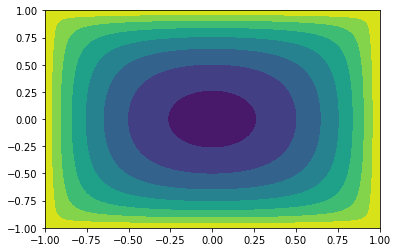

In [5]:
def A(x, r, p):
    return np.zeros((2, 2) + x.shape[1:])


def B(x, r, p):
    return np.ones(x.shape[1:])


bc = Domain.Dirichlet(Domain.Box([[-1, 1], [-1, 1]]), 0.0, x)

u = newton_root(SchemeDirichlet, np.zeros(x.shape[1:]), (A, B, bc, superbases))

plt.contourf(*x, u)
plt.show()

### 2.1. Comparison with the exact solution

Iteration: 1  Residue norm: 73.38824828669112


Iteration: 2  Residue norm: 2.5289149038949263


Iteration: 3  Residue norm: 0.7503878059341889


Iteration: 4  Residue norm: 0.08520012557306544


Iteration: 5  Residue norm: 0.004053121782701563


Iteration: 6  Residue norm: 1.0534494084835089e-05


Iteration: 7  Residue norm: 6.760325632626518e-11
Target residue reached. Terminating.


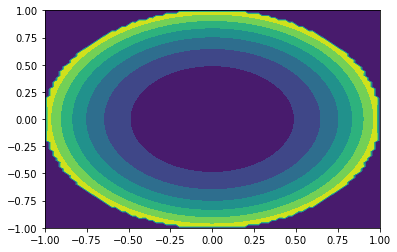

Error: 7.667856488336369e-05


In [6]:
def Exact(x):
    return (lp.dot_VV(x, x) + lp.dot_VV(x, x) ** 2) / 6


def A(x, r, p):
    return np.zeros((2, 2) + x.shape[1:])


def B(x, r, p):
    return (4 + 32 * lp.dot_VV(x, x) + 48 * lp.dot_VV(x, x) ** 2) / 36


bc = Domain.Dirichlet(Domain.Ball(), 1 / 3, x)

u = newton_root(SchemeDirichlet, np.zeros(x.shape[1:]), (A, B, bc, superbases))

plt.contourf(*x, u)
plt.show()

err = np.where(bc.interior, u - Exact(x), 0)
print("Error:", np.max(np.abs(err)))

Iteration: 1  Residue norm: 36654.50553736479


Iteration: 2  Residue norm: 8674.717093766165


Iteration: 3  Residue norm: 2035.9275470782238


Iteration: 4  Residue norm: 487.3753000166982


Iteration: 5  Residue norm: 118.7833238304581


Iteration: 6  Residue norm: 32.17804812794521


Iteration: 8  Residue norm: 92.45824056924926


Iteration: 10  Residue norm: 0.42407650415618026


Iteration: 12  Residue norm: 5.4434365681643726e-05


Iteration: 13  Residue norm: 3.0888092084069285e-10
Target residue reached. Terminating.


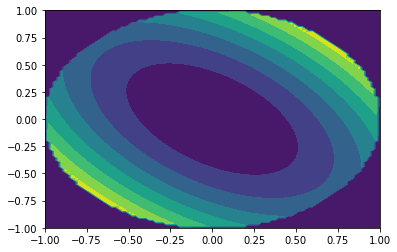

Error: 9.893138319005956e-06


In [7]:
Q = np.array([[2, 1], [1, 2]])
Q_inv = np.array([[2, -1], [-1, 2]]) / 3

assert np.allclose(Q @ Q_inv, np.eye(2))


def Exact(x):
    return lp.dot_VAV(x, np.multiply.outer(Q, np.ones(x.shape[1:])), x) / 2


def A(x, r, p):
    return -(
        r / 3 + lp.dot_VAV(p, np.multiply.outer(Q_inv, np.ones(x.shape[1:])), p) / 3
    ) * np.multiply.outer(Q, np.ones(x.shape[1:]))


def B(x, r, p):
    return (
        3
        * (
            1
            + 2 * r / 3
            + lp.dot_VAV(p, np.multiply.outer(Q_inv, np.ones(x.shape[1:])), p) / 6
        )
        ** 2
    )


bc = Domain.Dirichlet(Domain.Ball(), Exact, x)

u = newton_root(SchemeDirichlet, np.zeros(x.shape[1:]), (A, B, bc, superbases))

plt.contourf(*x, u)
plt.show()

err = np.where(bc.interior, u - Exact(x), 0)
print("Error:", np.max(np.abs(err)))

### 2.2. Other domains

Iteration: 1  Residue norm: 3.791943963628798


Iteration: 2  Residue norm: 1.1243754556408612


Iteration: 3  Residue norm: 0.14073444491339732


Iteration: 4  Residue norm: 0.04313700837978385


Iteration: 5  Residue norm: 0.00420841762238755


Iteration: 6  Residue norm: 6.915842973143072e-05


Iteration: 8  Residue norm: 5.895284260759581e-13
Target residue reached. Terminating.


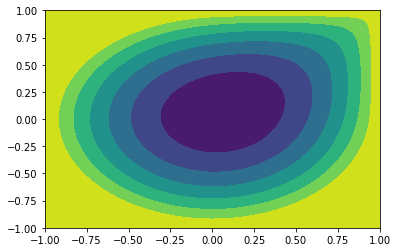

In [8]:
def A(x, r, p):
    return np.zeros((2, 2) + x.shape[1:])


def B(x, r, p):
    return np.ones(x.shape[1:])


bc = Domain.Dirichlet(Domain.Union(Domain.Ball(), Domain.Box()), 0.0, x)

u = newton_root(SchemeDirichlet, np.zeros(x.shape[1:]), (A, B, bc, superbases))

plt.contourf(*x, u)
plt.show()

Iteration: 1  Residue norm: 42.75527340343402


Iteration: 2  Residue norm: 147.8676508983342


Iteration: 3  Residue norm: 103.55434260303394


Iteration: 4  Residue norm: 17.479988009476486


Iteration: 5  Residue norm: 0.6784819067407497


Iteration: 6  Residue norm: 5.98286705703884


Iteration: 8  Residue norm: 0.4037764796193133


Iteration: 10  Residue norm: 0.06553648664526313


Iteration: 12  Residue norm: 0.00042153997258154163


Iteration: 14  Residue norm: 9.101608355877033e-13
Target residue reached. Terminating.


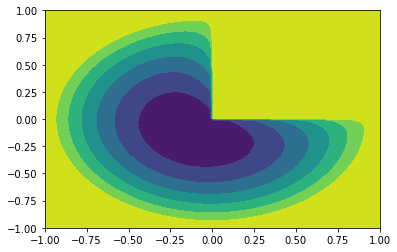

In [9]:
def A(x, r, p):
    return np.zeros((2, 2) + x.shape[1:])


def B(x, r, p):
    return np.ones(x.shape[1:])


bc = Domain.Dirichlet(Domain.Complement(Domain.Ball(), Domain.Box()), 0.0, x)

u = newton_root(SchemeDirichlet, np.zeros(x.shape[1:]), (A, B, bc, superbases))

plt.contourf(*x, u)
plt.show()

## 3. Optimal transport boundary conditions

In [10]:
class BV2(Domain.Dirichlet):
    def __init__(self, domain, grid):
        super().__init__(domain, np.inf, grid)

    def DiffUpwind(self, u, offsets, reth=False):
        du = super().DiffUpwind(u, offsets)

        du = np.where(du == np.inf, np.sqrt(lp.dot_VV(offsets, offsets)), du)

        if reth:
            return du, self.gridscale
        else:
            return du

    def DiffCentered(self, u, offsets):
        du0 = super().DiffUpwind(u, offsets)
        du1 = super().DiffUpwind(u, -np.asarray(offsets))

        # TODO
        assert np.sum(np.logical_and(du0 == np.inf, du1 == np.inf)) == 0

        du0 = np.where(du0 == np.inf, -du1, du0)
        du1 = np.where(du1 == np.inf, -du0, du1)

        return (du0 - du1) / 2

In [11]:
def SchemeBV2(u, A, B, bc, superbases):
    return np.where(
        bc.interior,
        MA(u, A, B, bc, superbases) + u.flatten()[np.argmin(bc.domain.level(bc.grid))],
        u - bc.grid_values,
    )

### 3.1. Comparison with the exact solution

Iteration: 1  Residue norm: 2069.1625072448423


Iteration: 2  Residue norm: 109.17028894899991


Iteration: 3  Residue norm: 37.0876350390643


Iteration: 4  Residue norm: 9.488205730153211


Iteration: 5  Residue norm: 3.1017757422972045


Iteration: 6  Residue norm: 0.5158981153493198


Iteration: 8  Residue norm: 0.00010778023492865468


Iteration: 9  Residue norm: 8.353138049310704e-09
Target residue reached. Terminating.


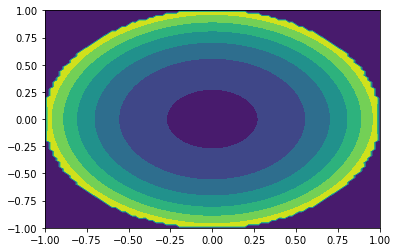

Error: 0.0692501375889793


In [12]:
def Exact(x):
    return (lp.dot_VV(x, x) + lp.dot_VV(x, x) ** 2) / 6


def A(x, r, p):
    return np.zeros((2, 2) + x.shape[1:])


def B(x, r, p):
    return (4 + 32 * lp.dot_VV(x, x) + 48 * lp.dot_VV(x, x) ** 2) / 36


bc = BV2(Domain.Ball(), x)

u = newton_root(SchemeBV2, np.zeros(x.shape[1:]), (A, B, bc, superbases))

plt.contourf(*x, u)
plt.show()

err = np.where(bc.interior, u - Exact(x), 0)
print("Error:", np.max(np.abs(err)))

Iteration: 1  Residue norm: 21.883080129849578


Iteration: 2  Residue norm: 2.0376171082699273


Iteration: 3  Residue norm: 1.3040322188231606


Iteration: 4  Residue norm: 0.1580956345189312


Iteration: 5  Residue norm: 0.0019236615455444535


Iteration: 6  Residue norm: 2.231450543545288e-07


Iteration: 7  Residue norm: 5.472913788828748e-13
Target residue reached. Terminating.


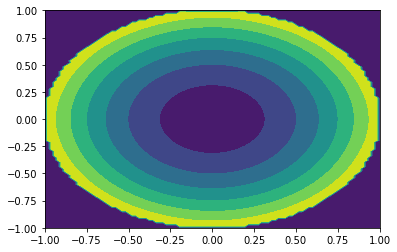

Error: 0.048291854590035155


In [13]:
def Exact(x):
    return lp.dot_VV(x, x) / 2


def A(x, r, p):
    return -(r / 3 + lp.dot_VV(p, p) / 3) * lp.identity(x.shape[1:])


def B(x, r, p):
    return (1 + 2 * r / 3 + lp.dot_VV(p, p) / 6) ** 2


bc = BV2(Domain.Ball(), x)

# TODO: initial guess
u = newton_root(SchemeBV2, lp.dot_VV(x, x), (A, B, bc, superbases))

plt.contourf(*x, u)
plt.show()

err = np.where(bc.interior, u - Exact(x), 0)
print("Error:", np.max(np.abs(err)))